<a href="https://colab.research.google.com/github/JaskeeratK/Context-is-Key/blob/main/context_is_key.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub pandas numpy groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 6.4 MB/s eta 0:00:00


In [2]:
!mkdir -p data

# Download the actual Walmart data files
!wget -O data/sales.csv https://raw.githubusercontent.com/Z-Fran/Walmart-Store-Sales-Forecasting/main/datasets/W%20store%20sales/sales.csv
!wget -O data/features.csv https://raw.githubusercontent.com/Z-Fran/Walmart-Store-Sales-Forecasting/main/datasets/W%20store%20sales/features.csv
!wget -O data/stores.csv https://raw.githubusercontent.com/Z-Fran/Walmart-Store-Sales-Forecasting/main/datasets/W%20store%20sales/stores.csv

print("files downloaded")

--2025-12-26 04:37:16--  https://raw.githubusercontent.com/Z-Fran/Walmart-Store-Sales-Forecasting/main/datasets/W%20store%20sales/sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12842546 (12M) [text/plain]
Saving to: ‘data/sales.csv’

data/sales.csv      100%[===================>]  12.25M  60.0MB/s    in 0.2s    

2025-12-26 04:37:17 (60.0 MB/s) - ‘data/sales.csv’ saved [12842546/12842546]

--2025-12-26 04:37:17--  https://raw.githubusercontent.com/Z-Fran/Walmart-Store-Sales-Forecasting/main/datasets/W%20store%20sales/features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connect

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

sales = pd.read_csv('data/sales.csv')
features = pd.read_csv('data/features.csv')
stores = pd.read_csv('data/stores.csv')

print("SALES DATA")
print(sales.head(10))
print(f"Shape: {sales.shape}")
print(f"Columns: {sales.columns.tolist()}")

print("\nFEATURES DATA")
print(features.head(10))
print(f"Shape: {features.shape}")
print(f"Columns: {features.columns.tolist()}")

print("\nSTORES DATA")
print(stores)
print(f"Shape: {stores.shape}")
print(f"Columns: {stores.columns.tolist()}")

# check data types and missing values
print("\nSales missing values:")
print(sales.isnull().sum())
print("\nFeatures missing values:")
print(features.isnull().sum())
print("\nStores missing values:")
print(stores.isnull().sum())

SALES DATA
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
5      1     1  2010-03-12      21043.39      False
6      1     1  2010-03-19      22136.64      False
7      1     1  2010-03-26      26229.21      False
8      1     1  2010-04-02      57258.43      False
9      1     1  2010-04-09      42960.91      False
Shape: (421570, 5)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

FEATURES DATA
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63  

In [4]:
# Convert dates to datetime
sales['Date'] = pd.to_datetime(sales['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge sales with features and stores
sales_full = sales.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
sales_full = sales_full.merge(stores, on='Store', how='left')

print("MERGED DATA")
print(f"Shape: {sales_full.shape}")
print(f"Columns: {sales_full.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(sales_full.head(10))

# analyze the data structure
print("\nDATA SUMMARY")
print(f"Date range: {sales_full['Date'].min()} to {sales_full['Date'].max()}")
print(f"Number of weeks: {sales_full['Date'].nunique()}")
print(f"Number of stores: {sales_full['Store'].nunique()}")
print(f"Number of departments: {sales_full['Dept'].nunique()}")
print(f"Total store-dept combinations: {len(sales_full.groupby(['Store', 'Dept']))}")

if 'Weekly_Sales' in sales_full.columns:
    print(f"\nWeekly Sales statistics:")
    print(sales_full['Weekly_Sales'].describe())
else:
    print(f"\nAvailable sales columns: {[col for col in sales_full.columns if 'sale' in col.lower()]}")

# Check store types
print(f"\nStore types distribution:")
print(stores['Type'].value_counts())

# Check department distribution
print(f"\nTop 10 departments by number of records:")
print(sales_full['Dept'].value_counts().head(10))

MERGED DATA
Shape: (421570, 16)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

First 10 rows:
   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   
5      1     1 2010-03-12      21043.39      False        57.79       2.667   
6      1     1 2010-03-19      22136.64      False        54.58       2.720   
7      1     1 2010-03-26      26229.21      False        51.45       2.732   
8      1     1 2010-04-02      57258.43     

In [5]:
class WalmartForecastTask:
    """
    Context-is-Key style forecasting task.
    Historical time series + non-inferable textual context.
    """

    def __init__(self, sales_df, store_id, dept_id,
                 history_weeks=52, forecast_weeks=8):

        self.store_id = store_id
        self.dept_id = dept_id
        self.history_weeks = history_weeks
        self.forecast_weeks = forecast_weeks

        # Filter series
        series = sales_df[
            (sales_df["Store"] == store_id) &
            (sales_df["Dept"] == dept_id)
        ].sort_values("Date").reset_index(drop=True)

        if len(series) < history_weeks + forecast_weeks:
            raise ValueError("Not enough data for this Store–Dept pair")

        self.full = series
        self.history = series.iloc[-(history_weeks + forecast_weeks):-forecast_weeks]
        self.future = series.iloc[-forecast_weeks:]

    # ---------- Context (CiK-compliant) ----------

    def build_context(self):
        """
        Context must contain information NOT directly inferable
        from historical sales alone.
        """

        store_type = self.history["Type"].iloc[0]
        store_size = int(self.history["Size"].iloc[0])

        future_holidays = self.future[self.future["IsHoliday"] == True]
        has_holiday = len(future_holidays) > 0

        # Directional holiday effect ONLY (no numbers)
        hist_holiday = self.history[self.history["IsHoliday"] == True]["Weekly_Sales"]
        hist_normal = self.history[self.history["IsHoliday"] == False]["Weekly_Sales"]

        if len(hist_holiday) > 0 and hist_holiday.mean() < hist_normal.mean():
            holiday_effect = "lower than normal"
        elif len(hist_holiday) > 0:
            holiday_effect = "higher than normal"
        else:
            holiday_effect = "inconsistent"

        context = f"""
This series represents weekly sales for a retail department.

BACKGROUND:
- Store type: {store_type}
- Store size: large-format store

CALENDAR CONTEXT:
- Forecast period: {self.future.iloc[0]['Date'].date()} to {self.future.iloc[-1]['Date'].date()}
- Holiday weeks present: {"Yes" if has_holiday else "No"}

HISTORICAL INSIGHT:
- Holiday weeks historically show {holiday_effect} sales for this department.

EVENT CONTEXT:
- No major promotions or pricing changes are planned.
- No known operational disruptions are expected.
"""
        return context.strip()

    # ---------- Prompt ----------

    def build_prompt(self):
        history_values = self.history["Weekly_Sales"].tolist()
        context = self.build_context()

        prompt = f"""
{context}

HISTORICAL WEEKLY SALES:
{history_values}

TASK:
Forecast sales for the next {self.forecast_weeks} weeks.

OUTPUT FORMAT:
Return ONLY a JSON array of {self.forecast_weeks} numbers.
"""
        return prompt.strip()

    # ---------- Utilities ----------

    def plot(self):
        plt.figure(figsize=(14,4))
        plt.plot(self.history["Date"], self.history["Weekly_Sales"], label="History")
        plt.plot(self.future["Date"], self.future["Weekly_Sales"], label="Future (GT)")
        plt.axvline(self.future.iloc[0]["Date"], color="black", linestyle="--")
        plt.legend()
        plt.title(f"Store {self.store_id}, Dept {self.dept_id}")
        plt.show()


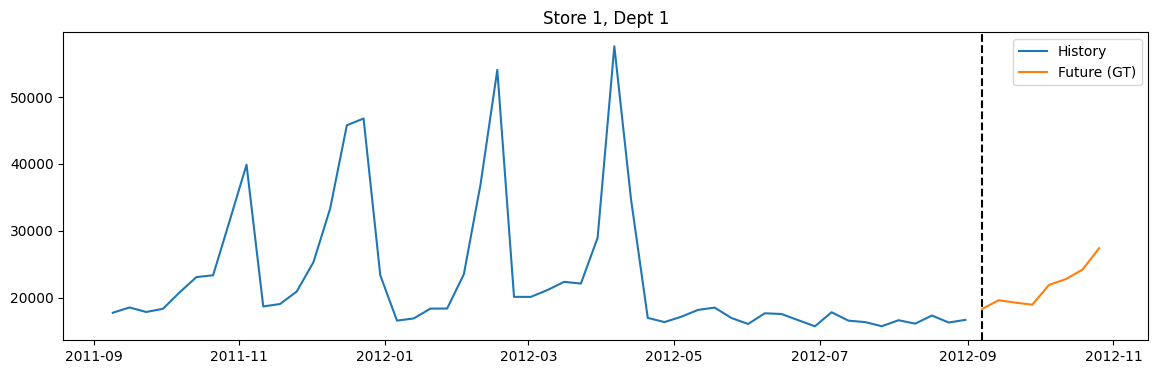

In [6]:
# Choose store–dept with enough history
pairs = (
    sales_full
    .groupby(["Store", "Dept"])
    .size()
    .reset_index(name="count")
)

valid_pairs = pairs[pairs["count"] >= 70]
store_id, dept_id = valid_pairs.iloc[0][["Store", "Dept"]]

task = WalmartForecastTask(
    sales_df=sales_full,
    store_id=store_id,
    dept_id=dept_id,
    history_weeks=52,
    forecast_weeks=8
)

task.plot()


In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
y_train = task.history["Weekly_Sales"].values
y_true = task.future["Weekly_Sales"].values

arima = ARIMA(y_train, order=(1,1,1)).fit()
arima_pred = arima.forecast(steps=8)

arima_mae = mean_absolute_error(y_true, arima_pred)

In [10]:
from groq import Groq
import json
import os
os.environ["GROQ_API_KEY"] = "groq-api-key"
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

history_only_prompt = f"""
Historical weekly sales:
{task.history["Weekly_Sales"].tolist()}

Forecast the next 8 weeks.
Return ONLY a JSON array of 8 numbers.
"""

print("=== CALLING LLM (NO CONTEXT) ===")
print("Sending prompt to Groq...")

response = client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {"role": "system", "content": "You are a forecasting expert. Output only JSON arrays."},
        {"role": "user", "content": history_only_prompt}
    ],
    temperature=0.0,
    max_tokens=200
)

# Get response
output = response.choices[0].message.content.strip()
print(f"\nLLM Raw Output:\n{output}")

# Parse JSON
# Remove markdown if present
if "```" in output:
    output = output.split("```")[1].replace("json", "").strip()

llm_no_context = json.loads(output)

print(f"\n✓ LLM predictions (no context):")
for i, pred in enumerate(llm_no_context, 1):
    print(f"  Week {i}: ${pred:,.2f}")

=== CALLING LLM (NO CONTEXT) ===
Sending prompt to Groq...

LLM Raw Output:
[17123.45, 17567.89, 18291.23, 19015.67, 18562.11, 17839.85, 17319.29, 16895.73]

✓ LLM predictions (no context):
  Week 1: $17,123.45
  Week 2: $17,567.89
  Week 3: $18,291.23
  Week 4: $19,015.67
  Week 5: $18,562.11
  Week 6: $17,839.85
  Week 7: $17,319.29
  Week 8: $16,895.73


In [13]:
context_prompt = task.build_prompt()
print("=== CALLING LLM (WITH CONTEXT) ===")
print("Sending prompt with holiday information...")

response = client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {"role": "system", "content": "You are a forecasting expert. Output only JSON arrays."},
        {"role": "user", "content": context_prompt}
    ],
    temperature=0.0,
    max_tokens=200
)

# Get response
output = response.choices[0].message.content.strip()
print(f"\nLLM Raw Output:\n{output}")

# Parse JSON
if "```" in output:
    output = output.split("```")[1].replace("json", "").strip()

llm_with_context = json.loads(output)

print(f"\n✓ LLM predictions (with context):")
for i, pred in enumerate(llm_with_context, 1):
    print(f"  Week {i}: ${pred:,.2f}")

=== CALLING LLM (WITH CONTEXT) ===
Sending prompt with holiday information...

LLM Raw Output:
[18321.59, 19083.21, 20115.38, 21547.92, 23689.55, 25411.19, 27139.85, 28867.51]

✓ LLM predictions (with context):
  Week 1: $18,321.59
  Week 2: $19,083.21
  Week 3: $20,115.38
  Week 4: $21,547.92
  Week 5: $23,689.55
  Week 6: $25,411.19
  Week 7: $27,139.85
  Week 8: $28,867.51


In [14]:
def evaluate(y_true, preds):
    return mean_absolute_error(y_true, preds)

results = pd.DataFrame({
    "Model": ["ARIMA", "LLM (No Context)", "LLM (With Context)"],
    "MAE": [
        evaluate(y_true, arima_pred),
        evaluate(y_true, llm_no_context),
        evaluate(y_true, llm_with_context)
    ]
})

# Context sensitivity gap
delta_context = (
    results.loc[1, "MAE"] - results.loc[2, "MAE"]
)

results, delta_context


(                Model          MAE
 0               ARIMA  2099.242481
 1    LLM (No Context)  3737.870000
 2  LLM (With Context)  1607.665000,
 np.float64(2130.205000000001))

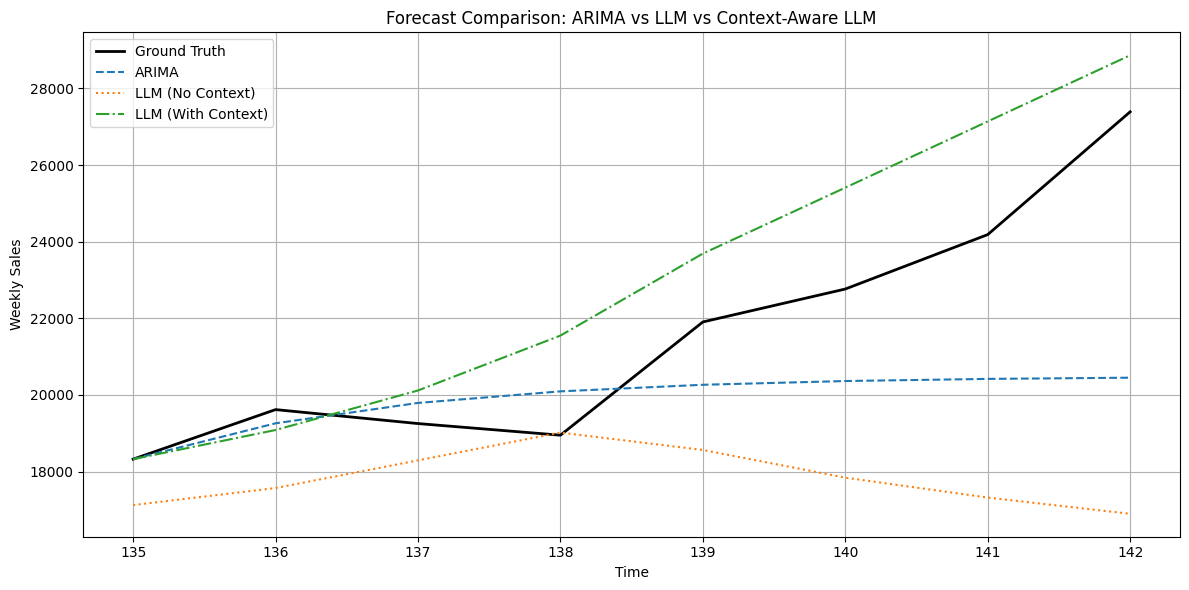

In [16]:
import matplotlib.pyplot as plt

# Use the test-period time index
timestamps = task.future.index

plt.figure(figsize=(12, 6))

plt.plot(
    timestamps,
    y_true,
    label="Ground Truth",
    color="black",
    linewidth=2
)

plt.plot(
    timestamps,
    arima_pred,
    label="ARIMA",
    linestyle="--"
)

plt.plot(
    timestamps,
    llm_no_context,
    label="LLM (No Context)",
    linestyle=":"
)

plt.plot(
    timestamps,
    llm_with_context,
    label="LLM (With Context)",
    linestyle="-."
)

plt.xlabel("Time")
plt.ylabel("Weekly Sales")
plt.title("Forecast Comparison: ARIMA vs LLM vs Context-Aware LLM")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
